<a href="https://colab.research.google.com/github/DGendooLab/scGPT-GBM-classifier/blob/main/final_analysis/scGPT_Post_Processing_UMAP_GBM_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glioblastoma scGPT Classifier (Full Analysis - UMAP Post Processing)

## Introduction

Based off the
[scGPT GitHub](https://www.github.com/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb/) tutorial.

### IMPORTANT:
Connect to a runtime (L4 is recommended for speed + cost) then:

__Tools -> Command Pallete -> "Use fallback runtime version" as scGPT is currently only available for Python<=3.10 and Google Colab has been updated to Python 3.11__  

With Google Colab Pro - Use L4 GPU (cheaper) or A100 GPU (faster for embedding tasks).

Use the scGPT-GBM workflow for T4 GPU (Google Colab Free) if you want to test without a subscription.

Pip Freeze Packages (Python 3.10.12) -> LAST CELL OF NOTEBOOK


In [ ]:
# connecting to your own google drive

from google.colab import drive
drive.mount('/content/drive')

!python3 --version # should return Python 3.10.12, if not make sure to follow instructions above to "Use Fallback Version"

Mounted at /content/drive
Python 3.10.12


In [ ]:
!pip install --upgrade torch
!pip install --upgrade torchvision
!pip install --upgrade scanpy
!pip install adjustText
!pip install igraph
!pip install louvain

cell_type_key = "annotation_level_3" # specific cell types
# cell_type_key = "cell_type" # broad cell types

import scanpy as sc
# concatenated AnnData from first pipeline (scGPT_Embedding_Tasks_GBM_Classifier.ipynb)
adata_concat = sc.read('/content/drive/My Drive/Richards_test_GBMAP_train_embed_full_concat.h5ad')

# AnnData embedding with predictions saved from end of first pipeline (scGPT_Embedding_Tasks_GBM_Classifier.ipynb)
# test_embed_adata = sc.read_h5ad('/content/drive/My Drive/Richards_test_embed_query_preds.h5ad')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<timed exec>:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


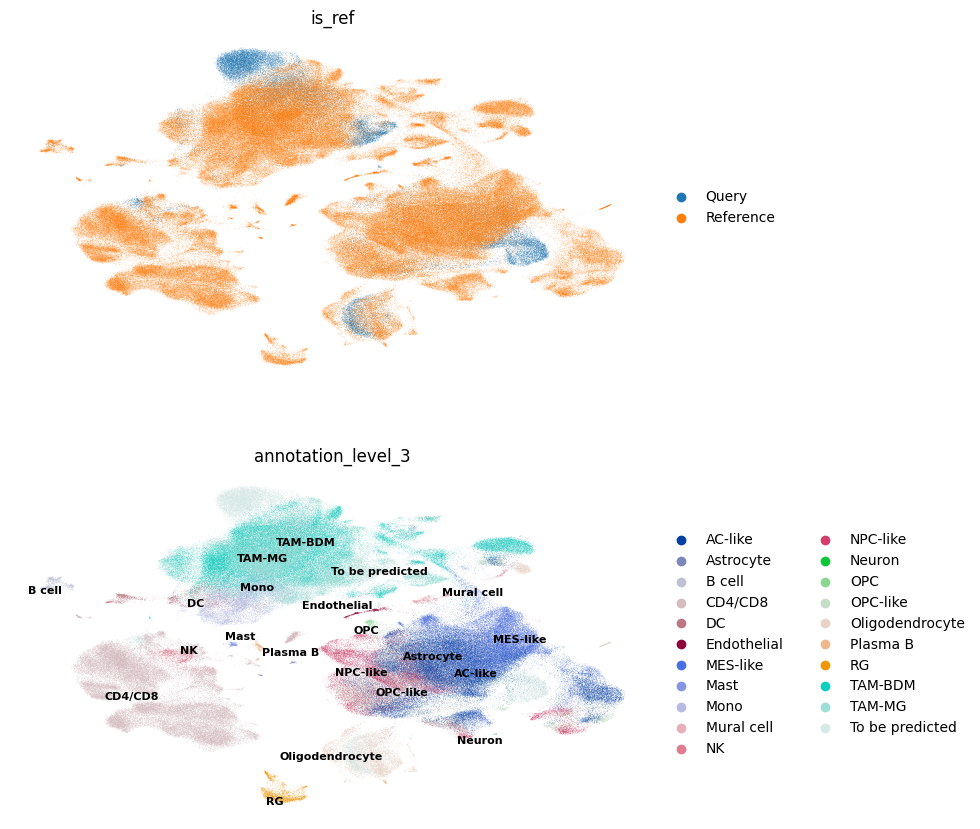

CPU times: user 20min 46s, sys: 11.7 s, total: 20min 58s
Wall time: 11min 52s


In [ ]:
%%time

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Assuming 'adata_concat' is your AnnData object and 'cell_type_key' is defined

# Compute the neighborhood graph and UMAP embedding
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.louvain(adata_concat, resolution=1.0)  # Adjust resolution as needed
sc.tl.umap(adata_concat)

# Plot the UMAP without displaying it immediately
sc.pl.umap(
    adata_concat,
    # color=["is_ref"],
    color=["is_ref", cell_type_key],
    wspace=0.4,
    frameon=False,
    ncols=1,
    show=False,
    # add_outline=True,  # Add an outline
    # outline_color=('blue', 'white'),  # Blue border with a white gap
    # outline_width=(0.3, 0.05),  # Adjust the width as needed
)

# Retrieve the UMAP coordinates
umap_coords = adata_concat.obsm['X_umap']

# Add UMAP coordinates to adata_concat.obs
adata_concat.obs['umap1'] = umap_coords[:, 0]
adata_concat.obs['umap2'] = umap_coords[:, 1]

# Calculate the median position for each cluster
grouped = adata_concat.obs.groupby(cell_type_key).median(numeric_only=True)

# Create text labels for each cluster
texts = []
for idx, row in grouped.iterrows():
    texts.append(
        plt.text(
            row['umap1'],
            row['umap2'],
            str(idx),
            fontsize=8,  # Small font size
            fontweight='bold',  # Bold text
            ha='center',
            va='center'
        )
    )

# Adjust text to minimize overlap
adjust_text(
    texts,
    # arrowprops=dict(arrowstyle='-', color='black'),
    arrowprops=None,  # No arrows
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=0.5,
    force_points=0.3
)

# Display the plot
plt.show()

## Optional ARI (Adjusted Rand Index) calculation for clustering performance

Requires test_embed_adata from first pipeline (scGPT_Embedding_Tasks_GBM_Classifier.ipynb)


In [ ]:
from sklearn.metrics import adjusted_rand_score
import numpy as np
import scanpy as sc

cell_type_key = "annotation_level_3"

# Append '-0' to each cell name in test_embed_adata
test_embed_adata2 = test_embed_adata

adata_concat2 = adata_concat
test_embed_adata2.obs_names = [f"{name}-0" for name in test_embed_adata2.obs_names]

# Make sure that the test_adata cells align with those in adata_concat
# For example, if adata_concat contains all cells (reference + test), and test_embed_adata is a subset,
# we can map predicted labels back:
adata_concat2.obs["predicted_cell_type"] = np.nan
adata_concat2.obs.loc[test_embed_adata2.obs_names, "predicted_cell_type"] = test_embed_adata2.obs["predicted_cell_type"]

# If you also want reference cells to show their actual cell type in the predicted column,
# you could fill those in by copying from the reference dataset or using the known labels:
ref_mask = adata_concat2.obs["is_ref"] == "Reference"
adata_concat2.obs.loc[ref_mask, "predicted_cell_type"] = adata_concat2.obs.loc[ref_mask, cell_type_key]

# Now you have a combined predicted_cell_type column in adata_concat that contains:
# - The original labels for the reference cells
# - The predicted labels for the test cells

ari_gbmap_filtered_richards = adjusted_rand_score(adata_concat2.obs["predicted_cell_type"], adata_concat2.obs[cell_type_key])
print("ARI_gbmap_filtered_richards:", ari_gbmap_filtered_richards)


<ipython-input-13-0318bcf65e6e>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['AC-like', 'AC-like', 'AC-like', 'AC-like', 'MES-like', ..., 'Oligodendrocyte', 'Oligodendrocyte', 'TAM-BDM', 'Oligodendrocyte', 'TAM-BDM']
Length: 40485
Categories (16, object): ['AC-like', 'B cell', 'CD4/CD8', 'DC', ..., 'Oligodendrocyte', 'Plasma B',
                          'TAM-BDM', 'TAM-MG']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_concat2.obs.loc[test_embed_adata2.obs_names, "predicted_cell_type"] = test_embed_adata2.obs["predicted_cell_type"]


ARI_gbmap_filtered_richards: 0.8154951917610281


## Pip Freeze Packages (Python 3.10.12):

In [ ]:
pip freeze

absl-py==1.4.0
accelerate==1.2.1
adjustText==1.3.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.10
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
anndata==0.11.3
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.10.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.16.0.35.48
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.29.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.1
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.12.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.88
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.31.2
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
